# Mixed Effects Linear Models

In [12]:
import pandas as pd
import numpy as np

In [13]:
df = pd.read_csv('../../data/tidy/paired_data/combined_with_knn.csv')
#df = pd.read_csv('../../data/tidy/paired_data/final_merged_results.csv')


In [14]:
directory_helm = '../../../hypo-predict/data/tidy_data/helmsley/'
directory_dexip = '../../../hypo-predict/data/tidy_data/dexip/'

In [15]:
# Upload preprocesed demographics data
helmsley_demo = pd.read_csv(directory_helm + 'demo_lab.csv')

dexip_demo = pd.read_csv(directory_dexip + 'demo_lab.csv')


# Combine all studies 
demo_lab = pd.concat([helmsley_demo, dexip_demo])

In [16]:
df['bout_id'] = df.index

In [17]:
df['start_datetime'] = pd.to_datetime(df['start_datetime'])
df['matched_time'] = pd.to_datetime(df['matched_time'])

In [18]:
df.rename(columns={'time_below_3.9':'time_below_3_9', 
            'time_3.9_to_10':'time_3_9_to_10',
            'matched_time_below_3.9':'matched_time_below_3_9',
          'matched_time_3.9_to_10':'matched_time_3_9_to_10',
}, inplace=True)

In [19]:
df_weight = pd.read_csv('../../../hypo-predict/data/tidy_data/demographics_df.csv')
df_weight.drop_duplicates(subset=['ID'], keep='first', inplace=True)
df = df.merge(df_weight[['ID', 'weight']], on='ID', how='inner')
df['iob_kg'] = df['IOB'] / df['weight']

In [20]:
df['matched_iob_kg'] = df['matched_IOB'] / df['weight']

### Preprocessing

In [23]:
df_ex = df[['bout_id', 'ID', 'start_datetime', 'duration', 'intensity', 'type_of_exercise',
       'finish_datetime', 'month', 'day', 'day_of_week', 'time_of_day',
       'form_of_exercise', 'time', 'glc',
        'start_roc', 'IOB', 'iob_kg',
        'cv',#'avg_glucose', 'sd_glucose', 'time_below_3_9', 'time_3_9_to_10',
       #'time_above_10', 'hbgi', 
       'glc_post_20', 'hypo']].copy() #'avg_glucose', 'sd_glucose', 'time_below_3.9', 'time_3.9_to_10','time_above_10', 'hbgi',

df_non_ex = df[['bout_id', 'ID','matched_time','duration',
       'matched_glc',  'matched_IOB', 'matched_iob_kg','matched_cv', 'matched_start_roc', 
       #'matched_avg_glucose', 'matched_sd_glucose', 'matched_time_below_3_9', 'matched_time_3_9_to_10',
       #'matched_time_above_10', 'matched_hbgi',
       'matched_glc_20_mins_post','hypo']].copy()

In [24]:
df_non_ex.columns = ['bout_id', 'ID', 'start_datetime', 'duration', 'glc',  'IOB', 'iob_kg', 'cv', 'start_roc', #'avg_glucose', 'sd_glucose', 'time_below_3_9', 'time_3_9_to_10',
       #'time_above_10', 'hbgi',
       'glc_post_20','hypo']

In [25]:
df_ex.dropna(subset=['intensity', 'form_of_exercise'], inplace=True)

In [26]:
df_ex['exercise'] = 1
df_non_ex['exercise'] = 0

df_comb = pd.concat([df_ex, df_non_ex])

In [27]:
df_comb['start_datetime'] = pd.to_datetime(df_comb['start_datetime'])

In [28]:
df_cut = df_comb[(df_comb['duration']<=30)&(df_comb['duration']>=10)] 
#df_cut = df_cut[df_cut['IOB']>0]
#df_cut = df_cut[~df_cut['start_glc_bins'].isin(['<4', '4-6', '6-8', '8-10'])]
#df_cut = df_cut[df_cut['glc']>10]

In [29]:
df_cut['glc_change'] = df_cut['glc_post_20']- df_cut['glc']


In [30]:
df_cut.dropna(subset=['glc_change', 'glc', 'cv',
       'start_roc', 'IOB'], inplace=True)

In [31]:
# Step 1: Create subsets based on flag
ex_subset = set(df_cut[df_cut['exercise'] == 1]['bout_id'])
pair_subset = set(df_cut[df_cut['exercise'] == 0]['bout_id'])

# Step 2: Find the intersection of bout_ids in both subsets
common_bout_ids = ex_subset.intersection(pair_subset)

# Step 3: Filter the original DataFrame
df_cut_final = df_cut[(df_cut['bout_id'].isin(common_bout_ids))]


In [32]:
df_cut_final['aer'] = df_cut_final['form_of_exercise']=='aer'
df_cut_final['ana'] = df_cut_final['form_of_exercise']=='ana'
df_cut_final['mix'] = df_cut_final['form_of_exercise']=='mix'


/tmp/ipykernel_277300/2226522863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut_final['aer'] = df_cut_final['form_of_exercise']=='aer'
/tmp/ipykernel_277300/2226522863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut_final['ana'] = df_cut_final['form_of_exercise']=='ana'
/tmp/ipykernel_277300/2226522863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [33]:
df_cut_final.reset_index(drop=True, inplace=True)

In [34]:
df_cut_final_demo = df_cut_final.merge(demo_lab, on='ID', how='left')

#df_cut_final_demo = df_cut_final_demo.dropna(subset=['hba1c', 'age', 'bmi'])

In [35]:
df_cut_final_demo['hour_of_day'] = df_cut_final_demo['start_datetime'].dt.hour

In [36]:
df_cut_final_demo['intensity'].fillna(-1, inplace=True)
df_cut_final_demo['form_of_exercise'].fillna('none', inplace=True)

/tmp/ipykernel_277300/362424199.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cut_final_demo['intensity'].fillna(-1, inplace=True)
/tmp/ipykernel_277300/362424199.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [37]:
df_cut_final_demo['aer'] = pd.to_numeric(df_cut_final_demo['aer'])
df_cut_final_demo['ana'] = pd.to_numeric(df_cut_final_demo['ana'])


In [38]:
df_cut_final_demo['light']  = df_cut_final_demo['intensity']==1
df_cut_final_demo['moderate'] = df_cut_final_demo['intensity']==2
df_cut_final_demo['vigorous'] = df_cut_final_demo['intensity']==3

In [39]:
df_cut_final_demo['female'] = pd.to_numeric(df_cut_final_demo['sex']=='female')

In [40]:
# iob/kg
#df_cut_final_demo['iob_bin'] = pd.cut(df_cut_final_demo['IOB/kg'], bins=[-float('inf'), 0.00536, 0.0267, float('inf')], labels=['<0.005', '0.005-0.027', '>0.027'])
#df_cut_final_demo['iob_bin'] = pd.cut(df_cut_final_demo['IOB'], bins=[-float('inf'), 0.01, 0.02,0.04, float('inf')], labels=['<0.01', '0.01-0.02','0.02-0.04', '>0.04'])
df_cut_final_demo['iob_bin'] = pd.qcut(df_cut_final_demo['IOB'], 5)

# age
df_cut_final_demo['age_bin'] = pd.cut(df_cut_final_demo['age'], bins=[-float('inf'), 20,40, 65, float('inf')], labels=['12-20', '20-40', '40-65', '65-80'])
# years since diagnosis
df_cut_final_demo['years_since_diagnosis_bin'] = pd.qcut(df_cut_final_demo['years_since_diagnosis'], q=3, labels=['0-10', '11-20', '>20'])

# bmi
df_cut_final_demo['bmi_bin'] = pd.cut(df_cut_final_demo['bmi'], bins=[0, 18.5, 24.9, 29.9, float('inf')], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# hba1c
df_cut_final_demo['hba1c_bin'] = pd.cut(df_cut_final_demo['hba1c'], bins=[0, 48, float('inf')], labels=['<48', '>=48'])

df_cut_final_demo['start_roc_bin'] = pd.cut(df_cut_final_demo['start_roc'], bins=[-float('inf'), -0.03, 0.03, float('inf')], labels=['Falling', 'Stable', 'Rising'])

df_cut_final_demo['glc_bin'] = pd.cut(df_cut_final_demo['glc'], bins=[10, 12, 15, float('inf')], labels=['10-12', '12-15', '>15'])

In [41]:
df_cut_final_demo.dropna(subset=['insulin_modality','age', 'bmi','intensity', 'hba1c', 'form_of_exercise', 'years_since_diagnosis_bin'], inplace=True)

In [42]:
df_cut_final_demo['pump'] = df_cut_final_demo['insulin_modality']=='pump'
df_cut_final_demo['mdi'] = df_cut_final_demo['insulin_modality']=='mdi'
df_cut_final_demo['closed_loop'] = df_cut_final_demo['insulin_modality']=='closed_loop'

In [43]:
df_cut_final_demo['iob_quadratic'] = df_cut_final_demo['IOB']**2
df_cut_final_demo['start_roc_quadratic'] = df_cut_final_demo['start_roc']**2
df_cut_final_demo['cv_quadratic'] = df_cut_final_demo['cv']**2
df_cut_final_demo['glc_quadratic'] = df_cut_final_demo['glc']**2
df_cut_final_demo['age_quadratic'] = df_cut_final_demo['age']**2
df_cut_final_demo['bmi_quadratic'] = df_cut_final_demo['bmi']**2

df_cut_final_demo['iob_cubed'] = df_cut_final_demo['IOB']**3
df_cut_final_demo['start_roc_cubed'] = df_cut_final_demo['start_roc']**3
df_cut_final_demo['cv_cubed'] = df_cut_final_demo['cv']**3
df_cut_final_demo['glc_cubed'] = df_cut_final_demo['glc']**3
df_cut_final_demo['age_cubed'] = df_cut_final_demo['age']**3
df_cut_final_demo['bmi_cubed'] = df_cut_final_demo['bmi']**3

In [44]:
df_cut_final_demo.to_csv('../../data/tidy/paired_data/final_data_for_analysis_iob_check.csv', index=False)

In [46]:
df_cut_final_demo[['duration', 'glc', 'start_roc', 'IOB', 'cv', 'hba1c', 'bmi', 'age', 'age_quadratic', 'glc_quadratic']] = df_cut_final_demo[['duration','glc', 'start_roc', 'IOB', 'cv', 'hba1c', 'bmi', 'age', 'age_quadratic', 'glc_quadratic']].apply(lambda x: (x - x.mean()), axis=0)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming 'glc_change' is your dependent variable and 'flag' is your main fixed effect
model = smf.mixedlm(
    "glc_change ~  exercise *(glc +  start_roc) ", #  +C(insulin_modality)+ age + bmi  time_3_9_to_10 +hour_of_day+ time_above_10 + hbgi + avg_glucose + + exercise:age + exercise:bmi
    data=df_cut_final_demo,
    groups="ID",  # Indidf_cut_final_demovidual-level random effect
    re_formula="~1+exercise",  # Allows random intercepts by ID
    vc_formula={"bout_id": "0 + C(bout_id)"},  # Nested pair-level random effect
)
result = model.fit(reml=True)


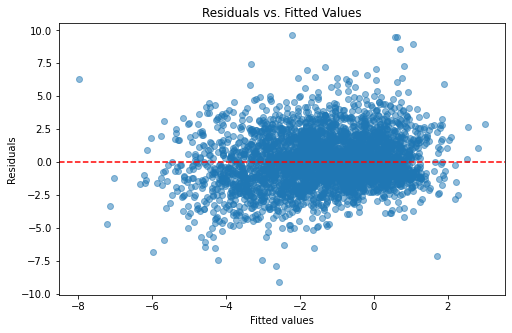

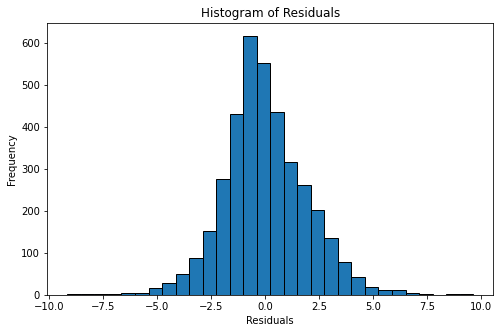

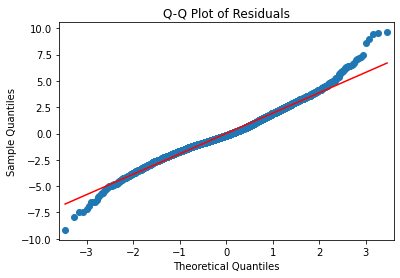

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm


# Extract fitted values and residuals
fitted_values = result.fittedvalues
residuals = result.resid

# 1. Residuals vs. Fitted Plot
plt.figure(figsize=(8, 5))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# 3. Q-Q Plot of Residuals
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()
